# Projet 3A SN :  Détection d'activité humaine - Apprentissage supervisé et non supervisé

**Nom du Groupe :**

**Noms :**

**Prénoms :**



Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

<img src="files/HARDataset.JPG" width="800" height="600"  >

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale)
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 5 séances se décomposent en 4 parties : 
- Partie I : Implémenter la DTW pour créer un système de reconnaissance;
- Partie II : Réduction de dimension par ACP et classification par kppv 
- Partie III : Classification par Forêts aléatoires
- Partie IV : Classification par réseaux de neurones
- Partie V : Votre étude

**Travail à rendre**

Pour cela, vous devez par binômes (effectif **OBLIGATOIRE**):
1. Implémenter la DTW pour créer un système de reconnaissance;
2. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
3. Réduction de dimension par ACP et classification par kppv 
4. Classification par Forêts aléatoires
5. Classification par réseaux de neurones
6. Rédiger un rapport en pdf présentant votre étude : les résultats par  méthode et vos commentaires et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages).


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [ ]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Data preprocessing
TIME_STEP = 60

# Model
N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=40
TAILLE_APP=20

## 1. Création des données d'apprentissage et de test

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw.txt


Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
Classe N° 0
Classe N° 1
Classe N° 2


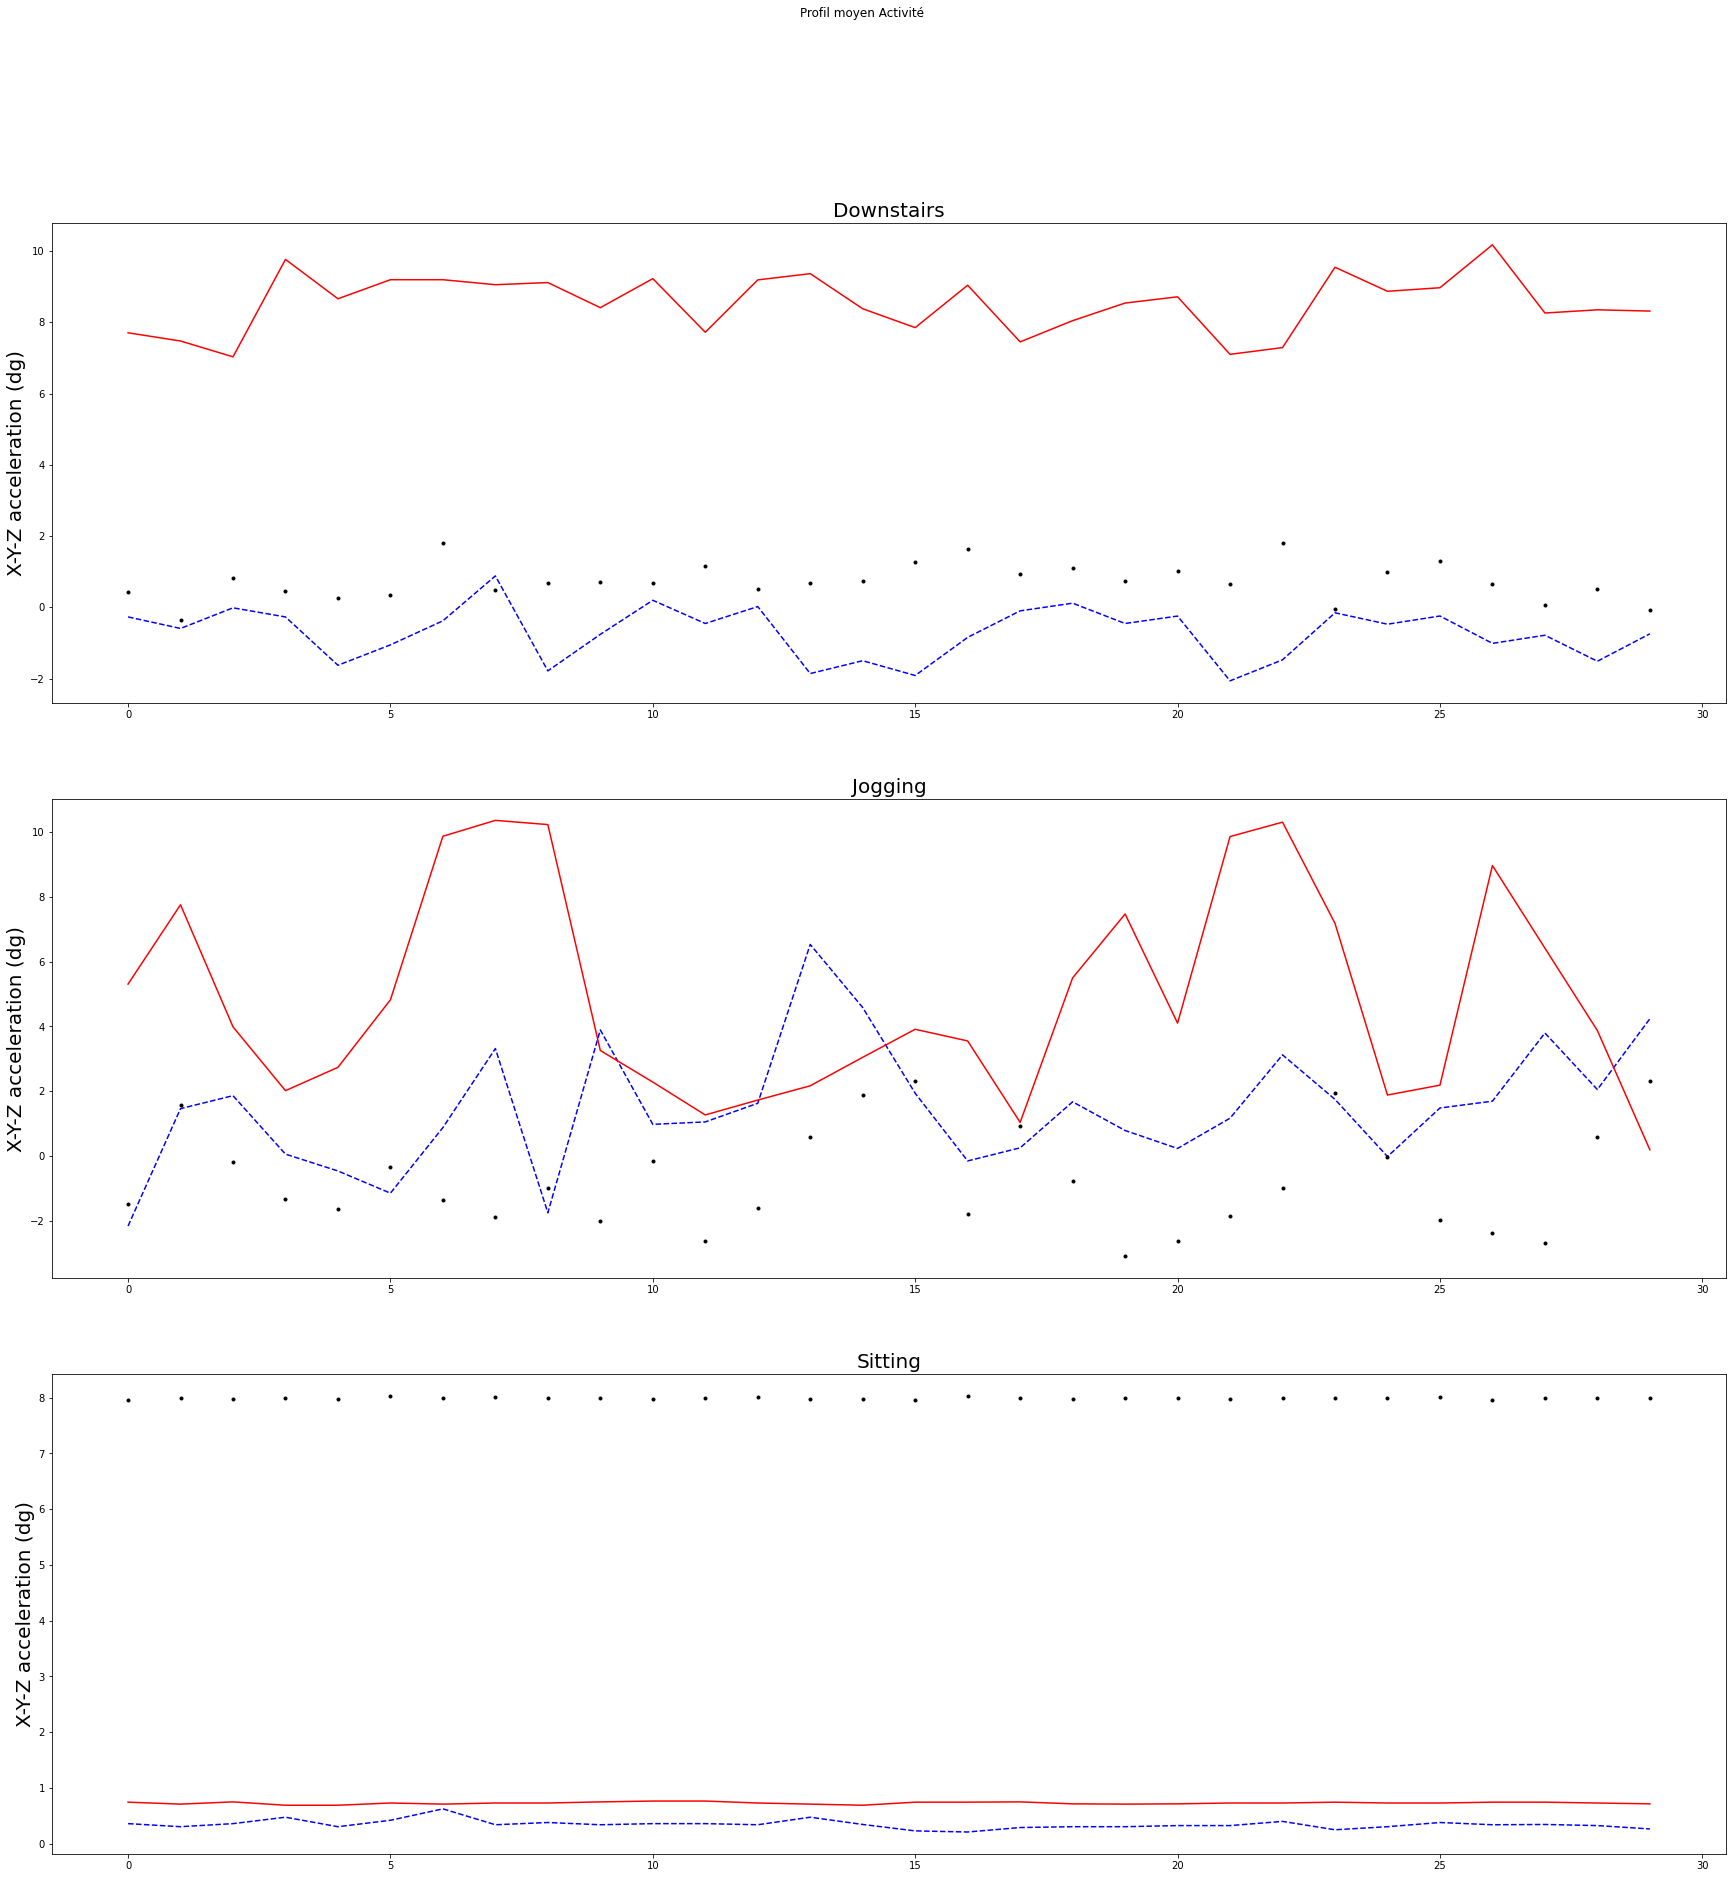

In [ ]:
# Chargement DATA
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()


data_convoluted = []
labels = []



# Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
# tous les TIME_STEP pour une même activité
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])
    # Label de l'activité associée à chaque segment
        label = j
        labels.append(label)


# Conversion numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

labels = np.asarray(labels, dtype=np.int)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)


fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

for i in range(N_CLASSES):
    # Selection des données correspondant à la classe i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Création de la base de Test
    tirage=np.random.randint(0,taille,TAILLE_TEST)
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    
    
    # Création de la base d'Apprentissage
    tirage1=np.random.randint(0,taille,TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    # Affichage du profil temporel moyen de la classe
    class1=np.median(tir_dataApp,axis=0)
    profil_median[i,:,:]=class1
    
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)




# Partie I : Implémentation de l'algorithme de programmation dynamique 

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en CTD. 

In [ ]:
def dist(p1,p2):
  return np.linalg.norm(p1 - p2)

def DTW_Matrix(A,B):
    M = len(A) # longueur de la première série
    N = len(B) # longueur de la deuxième série
    g = np.zeros((N,M),dtype=float) # initialisation de la matrice DTW
    
    for i in range(1,M):
        g[0,i] = dist(A[i],B[0]) + g[0,i-1]
    for i in range(1,N):
        g[i,0] = dist(A[0],B[i]) + g[i-1,0]
    for i in range(1,N):
        for j in range(1,M):
            cost = dist(A[j],B[i])
            g[i,j] = np.min([g[i-1,j] + cost, g[i,j-1] + cost, g[i-1,j-1] + cost])
    
    return g

In [ ]:
def score_DTW(g):
  N = np.shape(g)[0]
  M = np.shape(g)[1]

  return g[N-1,M-1]/(N+M)

In [ ]:
# Test de DTW
A = np.array([0, 1, 2, 4, 3])
B = np.array([1, 0, -1, 2])
g = DTW_Matrix(A, B)

score_DTW(g)

0.5555555555555556

2. Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes




In [ ]:
print("data_app size", np.shape(Data_App))
print("data test size", np.shape(Data_Test))
print("label test size", np.shape(Label_Test))
print("Label App size", np.shape(Label_App))
print("profil_median", np.shape(profil_median))
print("class1", np.shape(class1))

data_app size (60, 90)
data test size (120, 90)
label test size (120,)
Label App size (60,)
profil_median (3, 30, 3)
class1 (30, 3)


In [ ]:
# Les données d'apprentissage de label 0
Data_App_0 = Data_App[0:20, :]
print("Data_App_0 size :", np.shape(Data_App_0))

# Les données d'apprentissage de label 1
Data_App_1 = Data_App[20:40, :]
print("Data_App_1 size :", np.shape(Data_App_1))

# Les données d'apprentissage de label 2
Data_App_2 = Data_App[40:60, :]
print("Data_App_2 size :", np.shape(Data_App_2))


Data_App_0 size : (20, 90)
Data_App_1 size : (20, 90)
Data_App_2 size : (20, 90)


In [ ]:
# On sépare les données selon x y z

# Pour la classe1
Data_App_0_x = Data_App_0[:, 0:30]
Data_App_0_y = Data_App_0[:, 30:60]
Data_App_0_z = Data_App_0[:, 60:90]
print("Data_App_0_x size : ", np.shape(Data_App_0_x))

# Pour la classe 2
Data_App_1_x = Data_App_1[:, 0:30]
Data_App_1_y = Data_App_1[:, 30:60]
Data_App_1_z = Data_App_1[:, 60:90]

# Pour la classe 3
Data_App_2_x = Data_App_2[:, 0:30]
Data_App_2_y = Data_App_2[:, 30:60]
Data_App_2_z = Data_App_2[:, 60:90]

Data_App_0_x size :  (20, 30)


In [ ]:
# Les données de test avec le label 0
Data_Test_0 = Data_Test[0:40, :]
print("Data_Test_0 size :", np.shape(Data_Test_0))

# Les données de test avec le label 1
Data_Test_1 = Data_Test[40:80, :]
print("Data_Test_1 size :", np.shape(Data_Test_1))
# Les données de test avec le label 1
Data_Test_2 = Data_Test[80:, :]
print("Data_Test_2 size :", np.shape(Data_Test_2))

Data_Test_0 size : (40, 90)
Data_Test_1 size : (40, 90)
Data_Test_2 size : (40, 90)
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [ ]:
# On sépare les données selon x y z

# Pour la classe1
Data_Test_0_x = Data_Test_0[:, 0:30]
Data_Test_0_y = Data_Test_0[:, 30:60]
Data_Test_0_z = Data_Test_0[:, 60:90]
print("Data_Test_0_x size :", np.shape(Data_Test_0_x))

# Pour la classe 2
Data_Test_1_x = Data_Test_1[:, 0:30]
Data_Test_1_y = Data_Test_1[:, 30:60]
Data_Test_1_z = Data_Test_1[:, 60:90]

# Pour la classe 3
Data_Test_2_x = Data_Test_2[:, 0:30]
Data_Test_2_y = Data_Test_2[:, 30:60]
Data_Test_2_z = Data_Test_2[:, 60:90]

Data_Test_0_x size : (40, 30)


In [ ]:
# Les données médiane de la classe 1
median_class_1 = class1[:, 0]
print("median_class_1 size :", np.shape(median_class_1))
# Les données médiane de la classe 2
median_class_2 = class1[:, 1]
print("median_class_2 size :", np.shape(median_class_2))

# Les données médiane de la classe3
median_class_3 = class1[:, 2]
print("median_class_3 size :", np.shape(median_class_3))


median_class_1 size : (30,)
median_class_2 size : (30,)
median_class_3 size : (30,)


In [ ]:
# Valeur moyenne, x, y, z des données Data_Test_0
median_data_test_0 = (Data_Test_0_x + Data_Test_0_y + Data_Test_0_z)/3

# Pour chacune des données de Data_Test_0, on calcule leur distance DTW avec le profil moyen de la classe 0, ainsi que des classe 1 et 2.
nb_data = 40
res_0 = np.zeros((40, 3))
for i in range(0, 40):
  res_0[i, 0] = score_DTW(DTW_Matrix(median_data_test_0[i, :], median_class_1))
  res_0[i, 1] = score_DTW(DTW_Matrix(median_data_test_0[i, :], median_class_2))
  res_0[i, 2] = score_DTW(DTW_Matrix(median_data_test_0[i, :], median_class_3))

Pour chacune des données test 0, on regarde à quel classe est ce que la donnée est attribuée

In [ ]:
classe_res_0 = np.zeros((40, 1))
for i in range(0, 40):
  classe_res_0[i] = np.argmin(res_0[i, :])

On regarde le taux de réussite de notre méthode

In [ ]:
s = 0
for i in range(0, 40):
  if classe_res_0[i] == 0:
    s +=1
print(s, " données test de la classe 0 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de ", 100*(s/40), " %")

28  données test de la classe 0 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de  70.0  %


On fait pareil pour Data_App_1 et Data_App_2

In [ ]:
# Valeur moyenne, x, y, z des données Data_Test_1
median_data_test_1 = (Data_Test_1_x + Data_Test_1_y + Data_Test_1_z)/3

# Pour chacune des données de Data_Test_1, on calcule leur distance DTW avec le profil moyen de la classe 1, ainsi que des classe 0 et 2.
nb_data = 40
res_1 = np.zeros((nb_data, 3))
for i in range(0, nb_data):
  res_1[i, 0] = score_DTW(DTW_Matrix(median_data_test_1[i, :], median_class_1))
  res_1[i, 1] = score_DTW(DTW_Matrix(median_data_test_1[i, :], median_class_2))
  res_1[i, 2] = score_DTW(DTW_Matrix(median_data_test_1[i, :], median_class_3))

# classe_res donne, pour chaque données de Data_App_1, la classe à laquelle la donnée est associée
classe_res_1 = np.zeros((40, 1))
for i in range(0, 40):
  classe_res_1[i] = np.argmin(res_1[i, :])

# Le résultat
s = 0
for i in range(0, 40):
  if classe_res_1[i] == 1:
    s +=1
print(s, " données test de la classe 1 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de ", 100*(s/40), " %")


16  données test de la classe 1 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de  40.0  %


In [ ]:
# Valeur moyenne, x, y, z des données Data_Test_2
median_data_test_2 = (Data_Test_2_x + Data_Test_2_y + Data_Test_2_z)/3

# Pour chacune des données de Data_Test_2, on calcule leur distance DTW avec le profil moyen de la classe 2, ainsi que des classe 0 et 1.
nb_data = 40
res_2 = np.zeros((40, 3))
for i in range(0, 40):
  res_2[i, 0] = score_DTW(DTW_Matrix(median_data_test_2[i, :], median_class_1))
  res_2[i, 1] = score_DTW(DTW_Matrix(median_data_test_2[i, :], median_class_2))
  res_2[i, 2] = score_DTW(DTW_Matrix(median_data_test_2[i, :], median_class_3))

# classe_res donne, pour chaque donnée de Data_App_2, la classe à laqelle la donnée est associée
classe_res_2 = np.zeros((40, 1))
for i in range(0, 40):
  classe_res_2[i] = np.argmin(res_2[i, :])

s = 0
for i in range(0, 40):
  if classe_res_2[i] == 2:
    s +=1
print(s, " données test de la classe 3 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de ", 100*(s/40), " %")

14  données test de la classe 3 ont été attribué à la bonne classe sur 40, ce qui donne un taux de réussite de  35.0  %


3. A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

On calcule à présent la matrice de confusion

[[28. 11.  1.]
 [23. 17.  0.]
 [17.  9. 14.]]


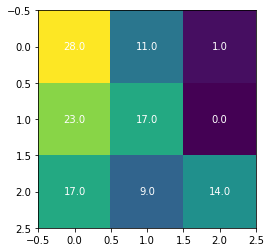

In [ ]:
matrice_confusion = np.zeros((3, 3))

# Première ligne
for i in range(0, 40):
  if classe_res_0[i] == 0:
    matrice_confusion[0, 0] += 1
  elif classe_res_0[i] == 1:
    matrice_confusion[0, 1] += 1
  else :
    matrice_confusion[0, 2] += 1

# Deuxième ligne
for i in range(0, 40):
  if classe_res_1[i] == 0:
    matrice_confusion[1, 0] += 1
  elif classe_res_1[i] == 1:
    matrice_confusion[1, 1] += 1
  else :
    matrice_confusion[1, 2] += 1

# Troisième ligne
for i in range(0, 40):
  if classe_res_2[i] == 0:
    matrice_confusion[2, 0] += 1
  elif classe_res_2[i] == 1:
    matrice_confusion[2, 1] += 1
  else :
    matrice_confusion[2, 2] += 1

# Print
print(matrice_confusion)
fig, ax = plt.subplots()
ax.imshow(matrice_confusion)

# Annotation
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(j, i, matrice_confusion[i, j],
                       ha="center", va="center", color="w")


# Partie II : Réduction de dimension par ACP et classification par kppv 

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.




In [ ]:
import sklearn

### Prétraitement par ACP

Pour tester une autre méthode de classification, 

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les 3 axes principaux de l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$.Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2X_3]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




In [ ]:
from sklearn.decomposition import PCA

### Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir. L'algorithme 1 associé et un exemple (figure 1) sont données par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par k-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.






# Partie III : Classification par Forêts aléatoires

Les forêts aléatoires font partie des techniques d'apprentissage automatique. Cet algorithme combine les concepts de sous-espaces aléatoires et de bagging. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

**Evaluation de la classification**

La performance des forêts aléatoires peut être estimée par : 
- **Accuracy score :** évaluation de la précision c'est-à-dire du nombre de données bien classées.
- **Out-of-bag estimate :**  méthode de mesure de l'erreur de prédiction des forêts aléatoires, des arbres de décision renforcés et d'autres modèles d'apprentissage utilisant l'agrégation bootstrap pour sous-échantillonner les données d'apprentissage. L'OOB est l'erreur moyenne de prédiction sur chaque échantillon d'apprentissage xᵢ, en utilisant uniquement les arbres qui n'avaient pas xᵢ dans leur échantillon bootstrap 




# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différentes solveurs

In [ ]:
from sklearn.neural_network import MLPClassifier

# Partie V : votre étude

Réalisez votre propre étude en :
- en augmentant les bases de test et/ou d'apprentissage et/ou la durée des segments 
- en proposant des variantes des méthodes proposées ou en utilisant d'autres
- en rajoutant davantage de classes (jusqu'à 3 supplémentaires : 4-Debout, 5-Monter ou 6-Marcher ) 
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport. 


